In [81]:
using PyPlot

In [107]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimize.jl");
include("../src/plotting.jl");

## Model setup

#### Physical parameters

In [108]:
# Model domain
t = Array(2020:1.:2200);

# "Best-guess equilibrium climate sensitivity"
ECS = 3.0;

#### Economic parameters

Assume damages of 2% of global world product (GWP) for 3$^{\circ}$C of warming (similar to DICE damage function).

In [121]:
GWP = 100. # global world product (trillion $ / year)

β = 0.02*GWP/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.025 # ρ (relative low value from Stern review)

# Control technology cost scales (for full deployment, α=1.)
reduce_cost = 0.01*GWP;
remove_cost = 0.02*GWP;
geoeng_cost = 0.05*GWP;
adapt_cost = 0.03*GWP;

In [122]:
baseline_emissions_scenario = baseline_emissions(t, 4., 2060., 40.)

economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0., # Assumed initial condition of no deployments in 2020
    baseline_emissions_scenario
);

### Initialize model

In [123]:
ensemble = Dict{String, ClimateModel}();

name = "Example configuration";
present_year = 2020.

# Arbitrary initial guess of climate control policies,
# to be optimized later!
controls = init_zero_controls(t);

# Create instance of idealized integrated assessment climate model
model = ClimateModel(name, ECS, t, controls, economics, present_year);

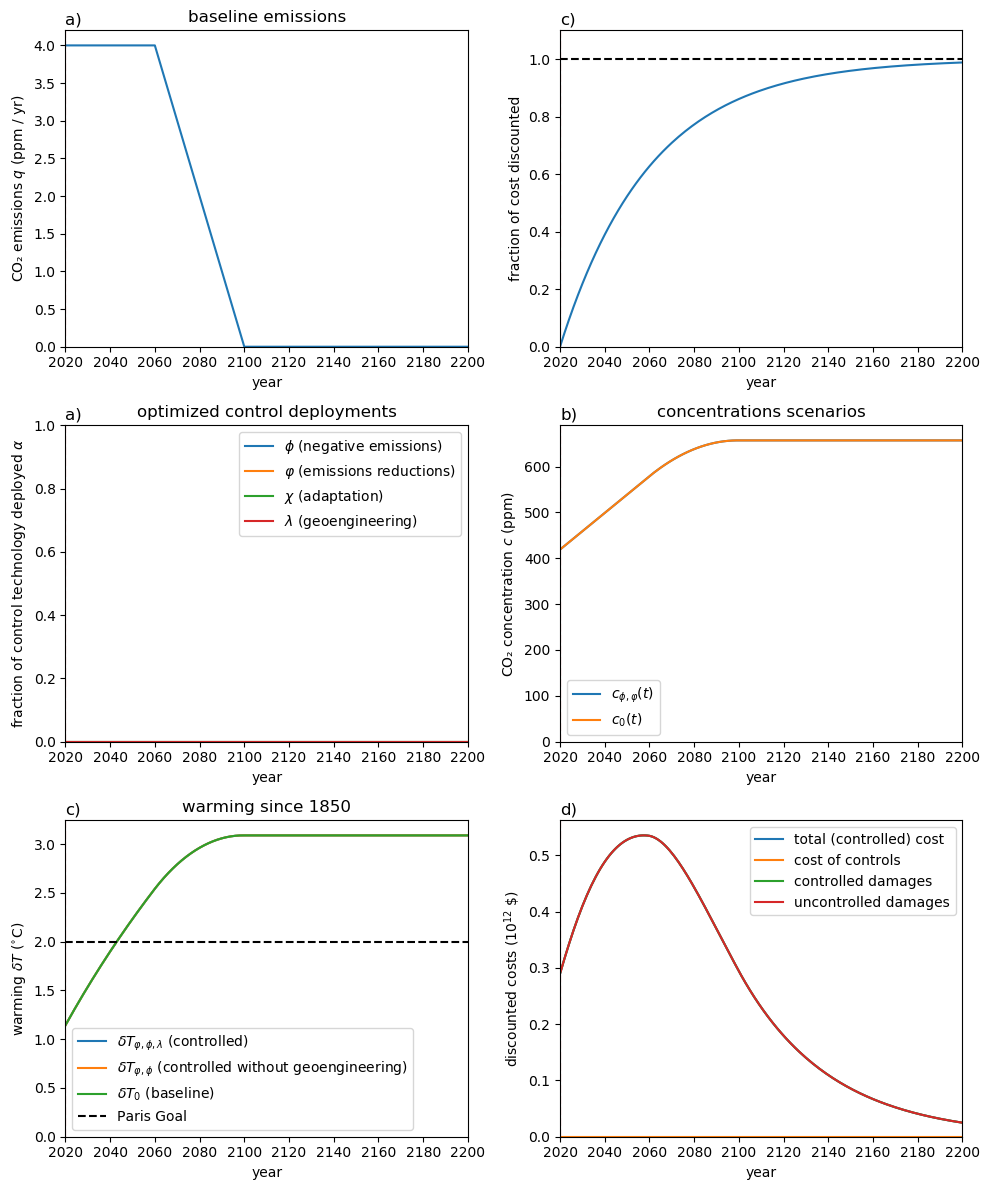

In [124]:
plot_state(model)

In [ ]:
print(string(
        "Social cost of carbon: \$",
        SCC(model),"."))

## Model optimization

In [125]:
# optimize model for lowest total (cumulative discounted) net (damages + controls) cost.
@time optimize!(model)
ensemble[model.name] = model;

Converged after 287 iterations.   8.154360 seconds (28.18 M allocations: 20.168 GiB, 11.54% gc time)


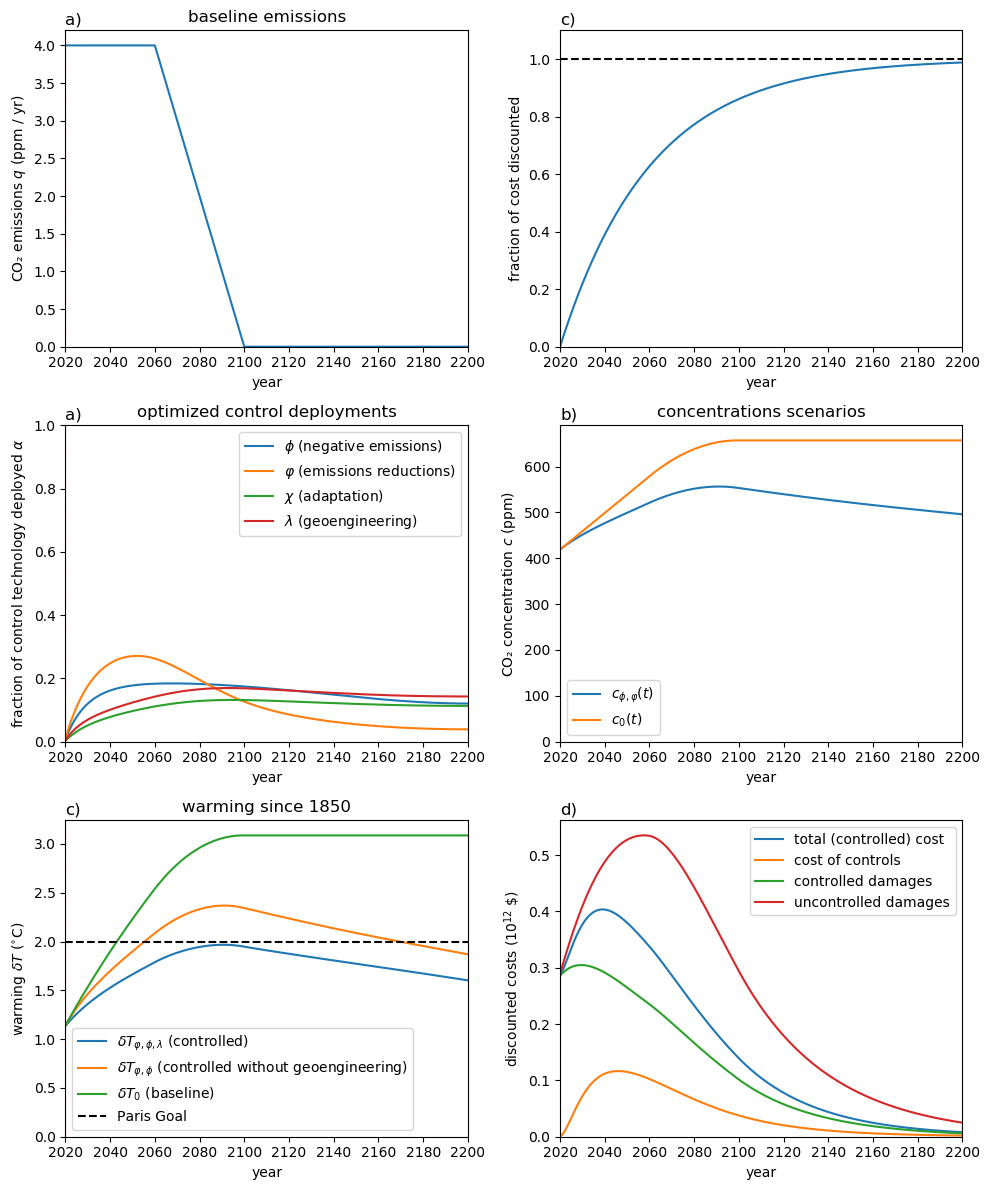

In [126]:
# plot optimized model state
plot_state(model)

In [127]:
print(string(
        "Social cost of carbon: \$",
        SCC(model),"."))

Social cost of carbon: $16.35.